In [1]:
import os
import numpy as np
import pandas as pd
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn import svm
from sklearn import preprocessing

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,
                             test_size=0.2)

for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / (len(y_train))))

In [5]:
from sklearn.metrics import make_scorer, f1_score

pipe = Pipeline([
    ("scaler", preprocessing.StandardScaler()),
    ("svc", svm.SVC(class_weight=weight_dict))
])

param_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": np.logspace(0, 3.5, 25),
    "svc__gamma": ["scale", 0.01, 0.1]
}

In [6]:
halving_clf = HalvingGridSearchCV(
    pipe,
    param_grid,
    scoring="f1_weighted",
    cv=5,
    factor=3,              # how aggressively configs are removed
    # min_resources="exhaust",
    verbose=3,
    n_jobs=-1
)

halving_clf.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 1071
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 75
n_resources: 40
Fitting 5 folds for each of 75 candidates, totalling 375 fits
----------
iter: 1
n_candidates: 25
n_resources: 120
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 2
n_candidates: 9
n_resources: 360
Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,Pipeline(step..._('X'): 5}))])
,param_grid,"{'svc__C': array([1.0000...16227766e+03]), 'svc__gamma': ['scale', 0.01, ...], 'svc__kernel': ['rbf']}"
,factor,3
,resource,'n_samples'
,max_resources,'auto'
,min_resources,'exhaust'
,aggressive_elimination,False
,cv,5
,scoring,'f1_weighted'
,refit,True
,error_score,nan


In [7]:
print("Best parameters:")
print(halving_clf.best_params_)

final_halving_model = halving_clf.best_estimator_


Best parameters:
{'svc__C': np.float64(28.729848333536655), 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


In [8]:
y_test_pred = final_halving_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           C       0.99      0.95      0.97        79
       Other       0.88      0.94      0.91        31
           S       0.98      0.99      0.99       110
           X       0.92      0.92      0.92        48

    accuracy                           0.96       268
   macro avg       0.94      0.95      0.94       268
weighted avg       0.96      0.96      0.96       268

[[ 75   0   0   4]
 [  0  29   2   0]
 [  0   1 109   0]
 [  1   3   0  44]]


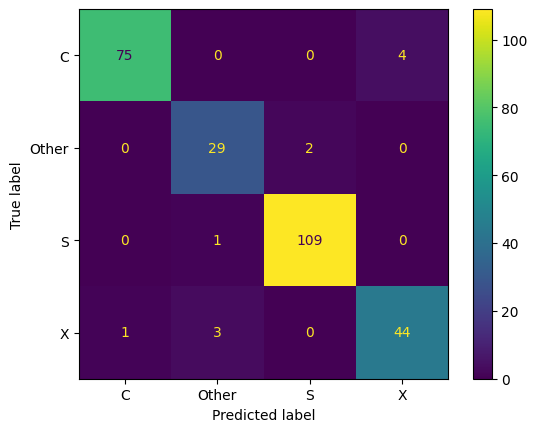

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    final_halving_model,
    X_test,
    y_test,
    values_format="d"
)

plt.show()

In [10]:
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.959
